In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip -q install -U ultralytics

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-23 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 640x640 9 cars, 2 traffic lights
Speed: 4.7ms pre-process, 2178.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 640)


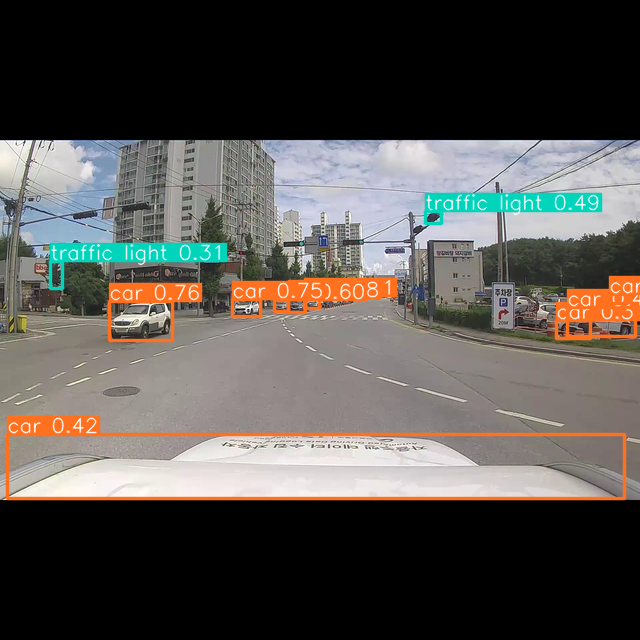

In [4]:
import torch
from PIL import Image
import matplotlib

def add_padding(img, target_width, target_height):
    width, height = img.size
    new_img = Image.new("RGB", (target_width, target_height), color="black")
    new_img.paste(img, ((target_width - width) // 2, (target_height - height) // 2))
    return new_img

# 이미지 패딩 추가 및 리사이즈
img_path = '/content/drive/MyDrive/data/2DB/training/images/AGS_DA_00C_BA_22090202_000471.jpg'
original_image = Image.open(img_path)
padded_image = add_padding(original_image, 1920, 1920)
resized_image = padded_image.resize((640, 640), Image.LANCZOS)

# Model
model_ex1 = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)

# 이미지를 모델에 통과
results = model_ex1(resized_image)
# Results
results.print()

# Bounding box를 포함한 이미지를 화면에 바로 표시
results.show()

In [5]:
import os
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np

from torchvision.transforms import functional as F
from PIL import ImageDraw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")

        self.image_files = sorted([f for f in tqdm(os.listdir(self.image_dir), desc="Loading Images") if f.endswith('.jpg')])

        self.label_map = {
            "none": 0,
            "car": 1,
            "truck": 2,
            "bus": 3,
            "special_vehicle": 4,
            "motorcycle": 5,
            "bicycle": 6,
            "pedestrian": 7,
            "traffic_sign": 8,
            "traffic_light": 9
        }
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.labels = []
        for idx in range(len(self.image_files)):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            label_path = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + ".json")

            with open(label_path, 'r', encoding='utf-8') as file:
                label_data = json.load(file)

            boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
            labels = [anno['Label'] for anno in label_data['Annotation']]

            targets = []
            for box, label in zip(boxes, labels):
                target = [self.label_map[label]] + box
                targets.append(target)

            self.labels.append(targets)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_path = os.path.join(self.image_dir, self.image_files[idx])
      label_path = img_path.replace("images", "labels").replace(".jpg", ".json")

      orig_img = Image.open(img_path)
      orig_width, orig_height = orig_img.size

      # Determine new size maintaining aspect ratio
      if orig_width > orig_height:
          new_width = 640
          new_height = int(orig_height * (640 / orig_width))
      else:
          new_height = 640
          new_width = int(orig_width * (640 / orig_height))

      # Calculate the gain and padding
      gain_w = new_width / orig_width
      gain_h = new_height / orig_height
      pad_w = (640 - new_width) / 2
      pad_h = (640 - new_height) / 2

      # Resize the image while maintaining aspect ratio
      img = orig_img.resize((new_width, new_height))

      # Pad to square 640x640
      img = ImageOps.expand(img, border=(int(pad_w), int(pad_h), int(pad_w), int(pad_h)), fill='black')
      img = self.transform(img)

      with open(label_path, 'r', encoding='utf-8') as file:
          label_data = json.load(file)

      boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
      labels = [anno['Label'] for anno in label_data['Annotation']]

      # Adjust bounding boxes after resize and pad
      boxes = [[(box[0] + box[2] / 2) * gain_w + pad_w,
                (box[1] + box[3] / 2) * gain_h + pad_h,
                box[2] * gain_w,
                box[3] * gain_h] for box in boxes]

      # Convert string labels to integer labels
      labels = [int(self.label_map[label]) for label in labels]

      # Convert boxes and labels to targets format for YOLOv5 compatibility
      targets = []
      for box, label in zip(boxes, labels):
          # Normalize the coordinates
          target = [label] + [coord/640 for coord in box]
          targets.append(target)

      targets = torch.tensor(targets, dtype=torch.float32)

      original_shape = (orig_height, orig_width)
      shapes = (original_shape, ((gain_h, gain_w), (pad_h, pad_w)))

      return img, targets, img_path, shapes

    def revert_transforms(self, boxes, orig_width, orig_height):
        """원래 이미지 크기로 바운딩 박스 좌표 변환"""
        width_ratio = orig_width / 640
        height_ratio = orig_height / 640
        boxes = [[box[0] * width_ratio, box[1] * height_ratio,
          box[2] * width_ratio, box[3] * height_ratio] for box in boxes]

        return boxes


Loading Images: 100%|██████████| 100/100 [00:00<00:00, 158754.88it/s]


Shape in training loop: (1080, 1920)

Image tensor: torch.Size([3, 640, 640])
Targets: torch.Size([9, 5])


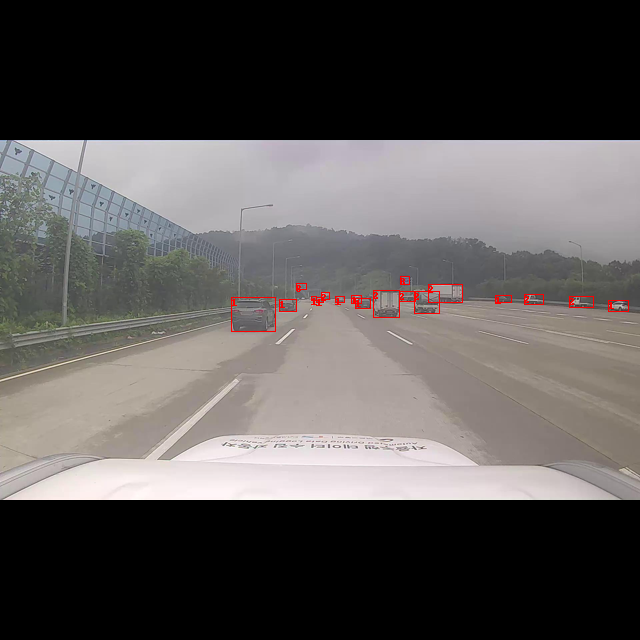

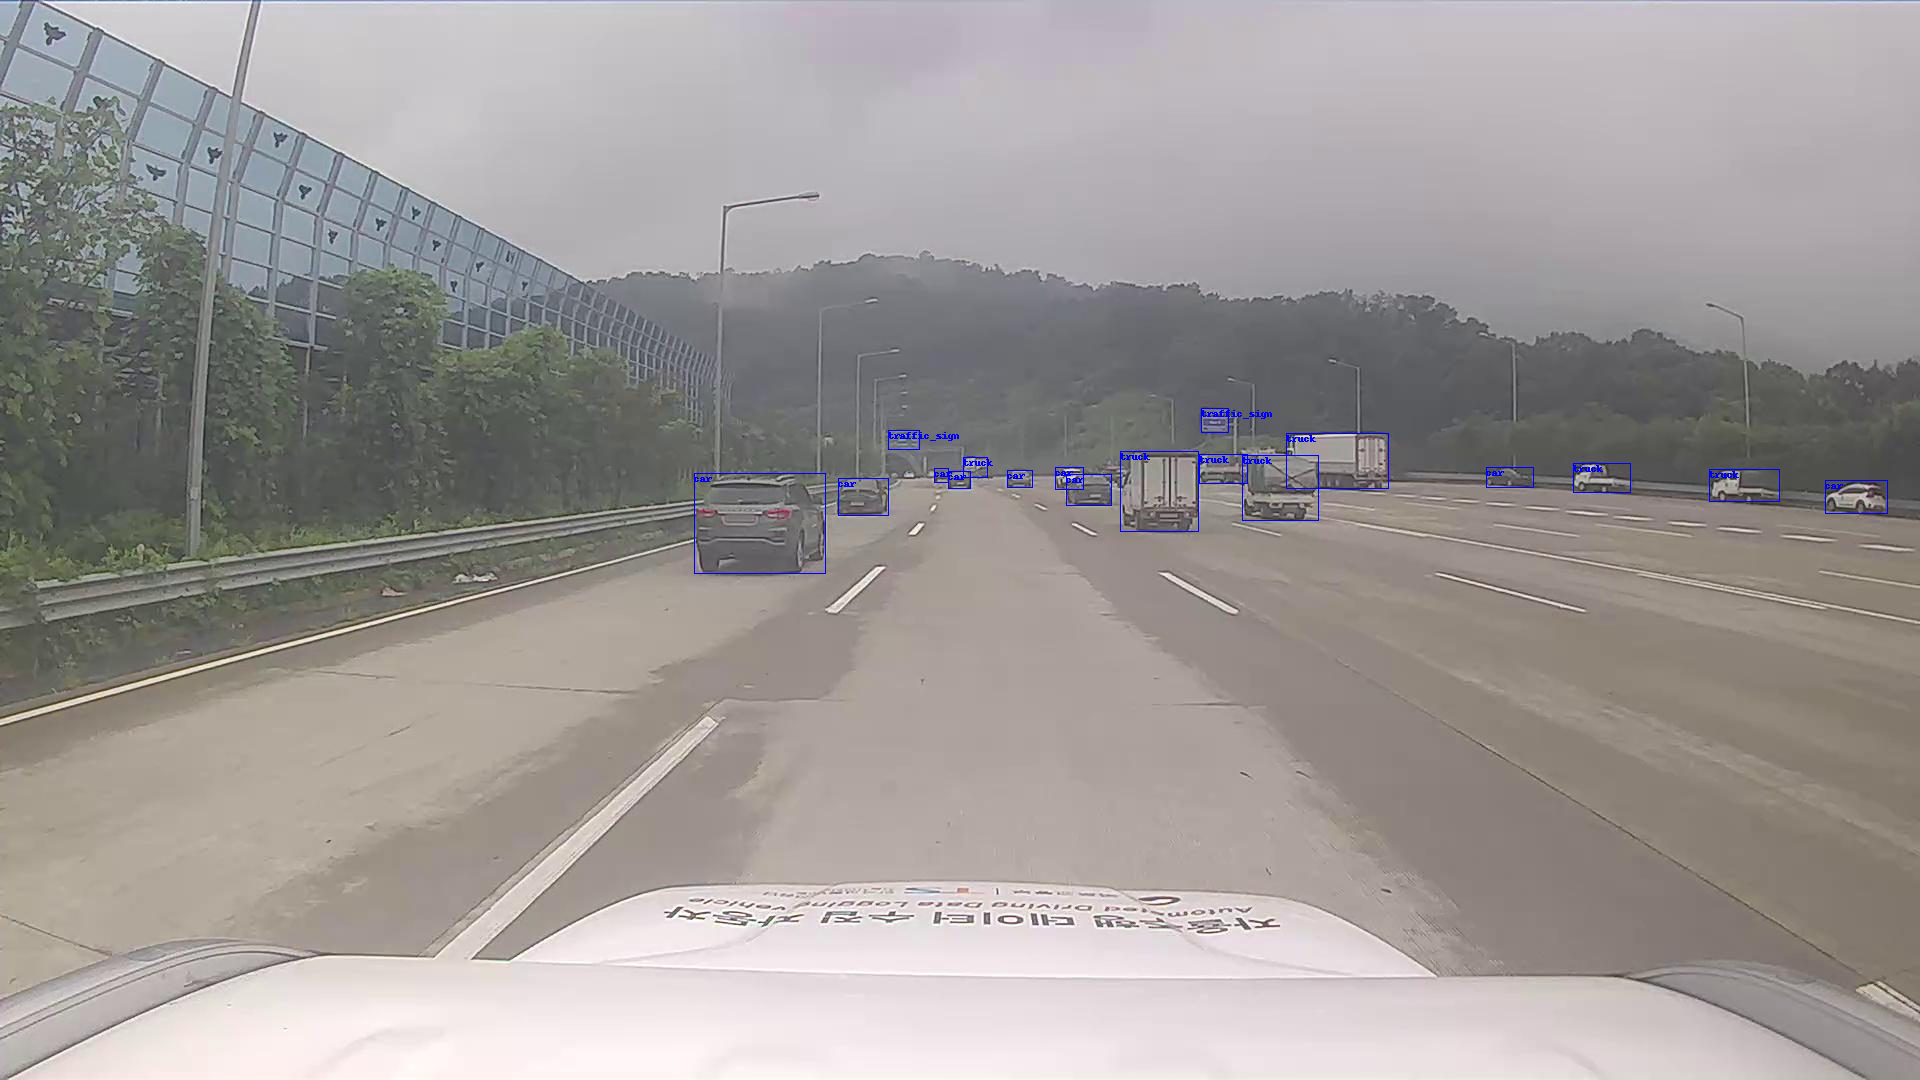

((1080, 1920), ((0.3333333333333333, 0.3333333333333333), (140.0, 0.0)))
Image path: /content/drive/MyDrive/data/2DB2/test/images/AGS_DA_00C_PR_22090201_001447.jpg
Shapes: ((1080, 1920), ((0.3333333333333333, 0.3333333333333333), (140.0, 0.0)))
[[[2, 304.95, 487.49, 27.15, 33.92], [1, 1640.92, 500.36, 119.7, 87.08], [0, 658.54, 422.71, 34.95, 23.3], [0, 345.45, 565.02, 33.55, 15.1], [1, 1568.14, 484.77, 141.8, 87.07], [1, 1540.85, 466.57, 74.21, 59.78], [1, 1695.51, 500.36, 201.57, 97.47], [0, 102.96, 366.94, 42.1, 28.12], [0, 343.4, 389.96, 264.2, 31.91], [9, 848.97, 301.75, 64.13, 21.95], [9, 1029.05, 297.14, 64.55, 19.26], [8, 605.77, 350.38, 55.13, 19.12], [8, 954.03, 285.48, 29.72, 34.2], [8, 1149.84, 322.67, 65.26, 19.53], [8, 1233.76, 431.48, 28.74, 28.82], [8, 1472.93, 421.67, 73.67, 154.03], [8, 780.63, 383.31, 35.17, 30.49], [0, 1301.88, 326.85, 118.92, 24.95], [0, 1184.58, 390.48, 38.09, 27.58], [9, 218.72, 208.84, 72.23, 32.28], [8, 300.38, 172.56, 45.12, 69.14], [9, 638.71

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    im, label, path, shapes = zip(*batch)  # transposed
    new_labels = []
    for i, lb in enumerate(label):
        img_idx_tensor = torch.full((lb.shape[0], 1), i, dtype=torch.float32)  # create a tensor filled with the image index
        new_labels.append(torch.cat((img_idx_tensor, lb), 1))  # prepend the image index to each target
    return torch.stack(im, 0), torch.cat(new_labels, 0), path, shapes

from IPython.display import display

def visualize_original_boxes(dataset, idx):
    img, _, img_path, _ = dataset[idx]
    orig_img = Image.open(img_path)  # Load original image without any transformations
    draw = ImageDraw.Draw(orig_img)

    label_path = img_path.replace("images", "labels").replace(".jpg", ".json")
    with open(label_path, 'r', encoding='utf-8') as file:
        label_data = json.load(file)

    boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
    labels = [anno['Label'] for anno in label_data['Annotation']]

    # Convert boxes from [x_min, y_min, width, height] to [x_cen, y_cen, width, height]
    boxes = [[box[0] + box[2] / 2, box[1] + box[3] / 2, box[2], box[3]] for box in boxes]

    for box, label in zip(boxes, labels):
        draw.rectangle([box[0] - box[2] / 2, box[1] - box[3] / 2, box[0] + box[2] / 2, box[1] + box[3] / 2], outline="blue")
        draw.text((box[0] - box[2] / 2, box[1] - box[3] / 2), label, fill="blue")

    display(orig_img)


def visualize_sample(dataset, idx):
    img, targets, _, _ = dataset[idx]
    img = F.to_pil_image(img.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                         torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1))
    draw = ImageDraw.Draw(img)

    for target in targets:
        label, x_cen, y_cen, w, h = target
        # Convert normalized coordinates to pixel coordinates
        x, y, w, h = x_cen*640, y_cen*640, w*640, h*640
        draw.rectangle([x - w / 2, y - h / 2, x + w / 2, y + h / 2], outline="red")
        draw.text((x - w / 2, y - h / 2), str(int(label)), fill="red")

    display(img)

# load dataset with loader
train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/training")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/validation")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB2/test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

# shape
img55, targets, img_path, shapes = test_dataset[3]  # get the 3th item
print("Shape in training loop:", shapes[0])  # print first item for brevity
print("\nImage tensor:", img55.shape)
print("Targets:", targets.shape)
visualize_sample(test_dataset, 0)
visualize_original_boxes(test_dataset, 0)
print(shapes[:5])
print("Image path:", img_path)
print("Shapes:", shapes)

# print(labels)
print(train_dataset.labels)
print(val_dataset.labels)
print(test_dataset.labels)

In [7]:
print(torch.cuda.is_available())

False


In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!git clone https://github.com/ultralytics/yolov5.git
import sys
sys.path.append('/content/YOLOv5/')

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [19]:
# Load the pretrained model
model = torch.hub.load('ultralytics/yolov5', 'yolov5l6', classes=10, autoshape=False, pretrained=True)
# Add the 'hyp' attribute if it doesn't exist
if not hasattr(model, 'hyp'):
    model.hyp = {
        "lr0": 0.01,
        "lrf": 0.1,
        "momentum": 0.937,
        "weight_decay": 0.0005,
        "warmup_epochs": 3.0,
        "warmup_momentum": 0.8,
        "warmup_bias_lr": 0.1,
        "box": 0.05,
        "cls": 0.3,
        "cls_pw": 1.0,
        "obj": 0.7,
        "obj_pw": 1.0,
        "iou_t": 0.20,
        "anchor_t": 4.0,
        "fl_gamma": 0.0,
        "hsv_h": 0,
        "hsv_s": 0,
        "hsv_v": 0,
        "degrees": 0.0,
        "translate": 0,
        "scale": 0,
        "shear": 0,
        "perspective": 0.0,
        "flipud": 0.0,
        "fliplr": 0.0,
        "mosaic": 0.0,
        "mixup": 0.0,
        "copy_paste": 0.0
    }
# Now you can access model.hyp without any issues
model.eval()
print(model.hyp)
img, _, _ , _ = train_dataset[1]
img = img.unsqueeze(0)
output = model(img)
print(len(output))
print(output[0].shape)
print(len(output[1]))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-23 Python-3.10.12 torch-2.0.1+cu118 CPU

Overriding model.yaml nc=80 with nc=10

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Conv                      [3, 64, 6, 2, 2]              
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  6   1118208  models.common.C3                        [256, 256, 6]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  6                -1  9   6433792  models.common.C3                        [512, 51

{'lr0': 0.01, 'lrf': 0.1, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.3, 'cls_pw': 1.0, 'obj': 0.7, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0, 'hsv_s': 0, 'hsv_v': 0, 'degrees': 0.0, 'translate': 0, 'scale': 0, 'shear': 0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.0, 'mosaic': 0.0, 'mixup': 0.0, 'copy_paste': 0.0}
2
torch.Size([1, 25500, 15])
4


In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch
# Define the Adam optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decays learning rate by 0.1 every 10 epochs
loss_fn = torch.nn.CrossEntropyLoss()

def print_results(dataset_name, loss, results):
    mp, mr, map50, map, *losses = results
    print(f"\n{dataset_name} Results:")
    print("-" * 50)
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {mp:.4f}")
    print(f"Recall: {mr:.4f}")
    print(f"mAP@0.5: {map50:.4f}")
    print(f"mAP@0.5:0.95: {map:.4f}")
    print(f"Box Loss: {losses[0]:.4f}")
    print(f"Obj Loss: {losses[1]:.4f}")
    print(f"Class Loss: {losses[2]:.4f}")
    print("-" * 50)

In [11]:
from tqdm import tqdm
from yolov5.val import run
from utils.loss import ComputeLoss

data_dict = {
    'val': 0,
    'nc': 10,
    'names': [
        'none',
        'car',
        'truck',
        'bus',
        'special_vehicle',
        'motorcycle',
        'bicycle',
        'pedestrian',
        'traffic_sign',
        'traffic_light'
    ]
}
def train_one_epoch(model, loader, num_epochs, epoch):
    model.train()
    running_loss = 0.0
    compute_loss = ComputeLoss(model)  # initialize the ComputeLoss class

    # Using tqdm to show progress bar
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels, _, _ = data
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute YOLO loss
        loss, _ = compute_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print(f'\n  batch {i + 1} loss: {last_loss}')
            running_loss = 0.0

    return last_loss


def evaluate(model, loader, task, device):
    model.eval()
    running_vloss = 0.0
    loss_fn = ComputeLoss(model.to(device))

    with torch.no_grad():
        for i, vdata in tqdm(enumerate(loader), total=len(loader), desc="Evaluating"):
            vinputs, vlabels, _, _ = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss, _ = loss_fn(voutputs[1], vlabels)
            running_vloss += vloss.item()

    # Compute mAP using the run function
    results, maps, _ = run(data=data_dict, task=task, device=device,
                           model=model, dataloader=loader, compute_loss=loss_fn)
    avg_vloss = running_vloss / len(loader)
    return avg_vloss, results, maps

In [12]:
num_epochs = 15

# Transfer Learning: Training the head only...
print("Transfer Learning: Training the head only...")
# Freeze specific layers for Transfer Learning

# 모든 gradients 비활성화
for param in model.parameters():
    param.requires_grad = False

# 마지막 검출 계층의 gradients 활성화
for param in model.model[-1].parameters():
    param.requires_grad = True

num_epochs_transfer = 10
for epoch in range(num_epochs_transfer):
    train_one_epoch(model, train_loader, num_epochs_transfer, epoch)
    val_loss, val_results, val_maps = evaluate(model, val_loader, 'val', device)
    print_results("Validation", val_loss, val_results)

# Fine-tuning: Training the entire model...
print("\nFine-tuning: Training the entire model...")
for param in model.parameters():
    param.requires_grad = True

num_epochs_fine_tuning = 10
for epoch in range(num_epochs_fine_tuning):
    train_one_epoch(model,train_loader, num_epochs_fine_tuning, epoch)
    val_loss, val_results, val_maps = evaluate(model, val_loader, 'val', device)
    print_results("Validation", val_loss, val_results)

Transfer Learning: Training the head only...


Epoch 1/10:   0%|          | 0/200 [00:12<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# test
test_loss, test_results, test_maps = evaluate(model, test_loader, 'test', device)
print_results("Test", test_loss, test_results)

{0: 'none', 1: 'car', 2: 'truck', 3: 'bus', 4: 'special_vehicle', 5: 'motorcycle', 6: 'bicycle', 7: 'pedestrian', 8: 'traffic_sign', 9: 'traffic_light'}


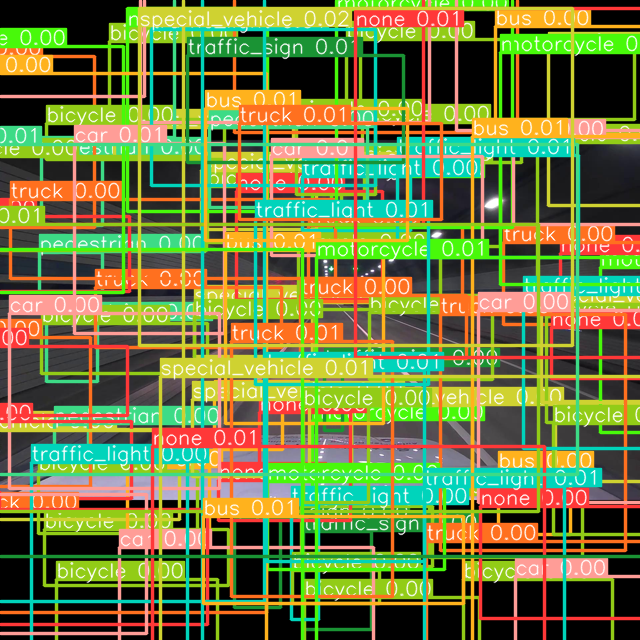

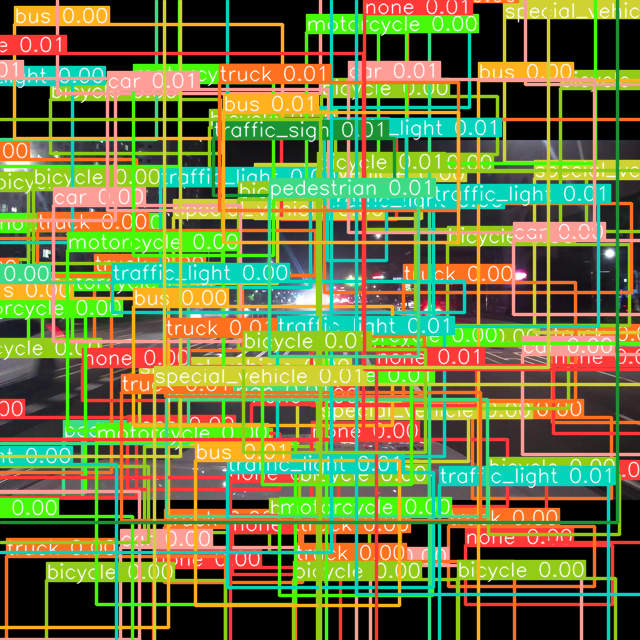

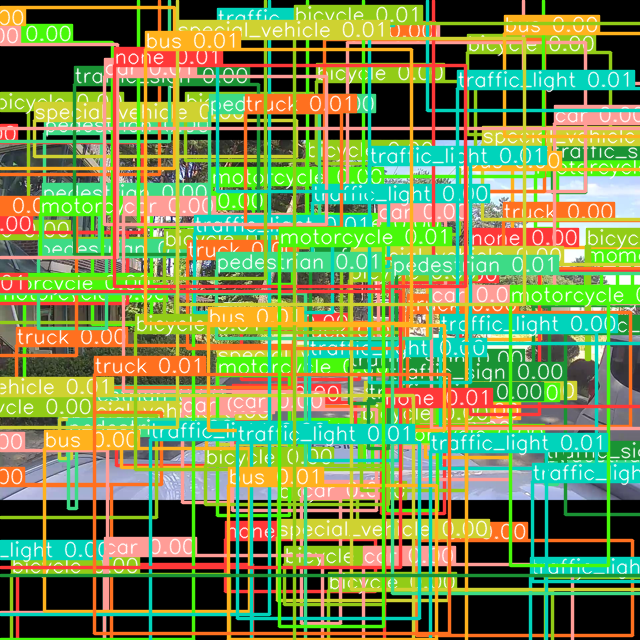

In [22]:
from PIL import Image
import os
from models.common import Detections
from utils.general import non_max_suppression
from IPython.display import display
from pathlib import Path

class TimeStamp:
    def __init__(self, t):
        self.t = t

times = (TimeStamp(0), TimeStamp(0), TimeStamp(0))

transform = transforms.Compose([
            transforms.Pad((0, 420, 0, 420)),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
# 1. Get predictions for all images
base_path = '/content/drive/MyDrive/data/2DB/test/images/'
img_names = os.listdir(base_path)[30:33]

# 1. Get predictions for all images
predictions = []
tensor_shapes = []
inverse_label_map = {v: k for k, v in train_dataset.label_map.items()}
print(inverse_label_map)


for img_name in img_names:
    image_path = Path(base_path) / img_name
    image = Image.open(image_path)
    tensor = transform(image).unsqueeze(0).to(device)
    tensor_shapes.append(tensor.shape)  # Store the tensor shape

    with torch.no_grad():
        result = model(tensor)
    nms_result = non_max_suppression(result[0], conf_thres=0.001, iou_thres=0.05)
    predictions.append(nms_result)

# 2. Visualize the predictions using Detections class
for img_name, prediction, shape in zip(img_names, predictions, tensor_shapes):
    image_path = Path(base_path) / img_name
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    left_pad = (1920 - width) // 2
    right_pad = 1920 - width - left_pad
    top_pad = (1920 - height) // 2
    bottom_pad = 1920 - height - top_pad

    # Step 3: Apply the padding
    image_padded = ImageOps.expand(image, (left_pad, top_pad, right_pad, bottom_pad), fill='black')

    # Step 4: Resize the padded image to 640x640
    image_resized = image_padded.resize((640, 640))
    # Convert PIL Image to numpy for Detections class
    image_np = np.array(image_resized)

    # Create Detections object and display
    detections = Detections(ims=[image_np], pred=prediction, files=[img_name], names=inverse_label_map, times=times, shape=shape)
    detections.show()

